# Demand Forecast Comparison – Jan to May 2025

This notebook analyzes and compares weekly shipment forecasts from three sources against actual shipment data for the period **January to May 2025**:

- **ASU Forecast (XGBoost Model):** Developed using historical shipment data (2023–2024) with multi-horizon forecasting for 21 weeks into 2025.
- **Customer Forecast Old:** Original customer forecast provided before March 2025.
- **Customer Forecast New:** Updated customer forecast shared from March to May 2025.
- **Actual Shipments:** Aggregated weekly shipment quantities observed in 2025.

## Key Objectives:
- Evaluate the accuracy of ASU’s ML-based forecast against actual shipment behavior.
- Compare customer-provided forecasts (old and new) to assess forecasting alignment and responsiveness.
- Visualize all four series (ASU, customer old, customer new, actuals) to highlight deviation and improvements over time.

## Data Sources:
- `Historical Demand (Shipments) Capstone Data(result).csv`
- `Forecast Demand Capstone Data(Forecast Demand) (1).csv`
- `Forecast Demand Capstone result).csv`

---

The plot below illustrates the performance of each forecast method compared to actual demand. It helps identify which forecasting approach was most aligned with real shipment patterns and where improvements are needed.


## **XGBoost Forecast – Overall Prediction Overview**

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

Week t+1 forecast: 1,265,436
Week t+2 forecast: 1,272,378
Week t+3 forecast: 1,241,680
Week t+4 forecast: 1,865,225
Week t+5 forecast: 2,173,416
Week t+6 forecast: 1,688,807
Week t+7 forecast: 2,112,206
Week t+8 forecast: 1,758,477
Week t+9 forecast: 2,539,904
Week t+10 forecast: 1,743,707
Week t+11 forecast: 1,213,548
Week t+12 forecast: 1,101,272
Week t+13 forecast: 2,028,328
Week t+14 forecast: 1,643,050
Week t+15 forecast: 1,878,037
Week t+16 forecast: 1,940,400
Week t+17 forecast: 1,333,453
Week t+18 forecast: 1,094,537
Week t+19 forecast: 1,115,080
Week t+20 forecast: 1,609,053
Week t+21 forecast: 1,304,341


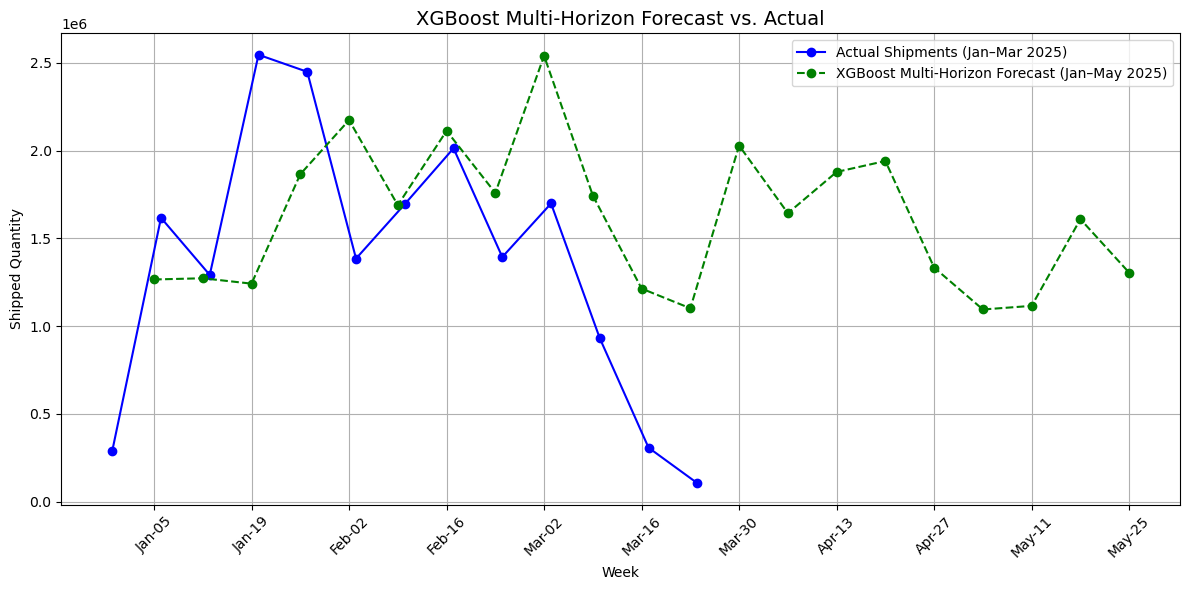


Multi-Horizon XGBoost Model Performance:
MAPE (Jan–May): 2.0500
RMSE (Jan–May): 768,209.04


In [3]:
# Loading  dataset and parsing data columns
file_path = r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Historical Demand (Shipments) Capstone Data(result).csv"
df = pd.read_csv(file_path)
df['Customer_Required_Date_CRD'] = pd.to_datetime(df['Customer_Required_Date_CRD'], format='%m/%d/%Y')

# Here we filter the data in order to demonstrate 2023 and 2024 data
df_train = df[df['Customer_Required_Date_CRD'] < '2025-01-01']

# This step include aggregating weekly shipped quantity
weekly = df_train.groupby(df_train['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum()
weekly = weekly.to_timestamp().reset_index()
weekly.rename(columns={'Customer_Required_Date_CRD': 'Week_Start'}, inplace=True)

#Demonstrating feature engineering: add time-based features
weekly['Week'] = weekly['Week_Start'].dt.isocalendar().week
weekly['Month'] = weekly['Week_Start'].dt.month
weekly['Quarter'] = weekly['Week_Start'].dt.quarter

# Adding  basic lag features and rolling statistics
for lag in range(1, 6):
    weekly[f'Lag{lag}'] = weekly['Shipped_Qty'].shift(lag)
weekly['RollingMean3'] = weekly['Shipped_Qty'].rolling(3).mean().shift(1)

# Removing rows with missing values cause by lag/rolling calculations
weekly.dropna(inplace=True)
weekly.reset_index(drop=True, inplace=True)

# Creating multi-step targets  (21 weeks ahead)
horizon = 21
for step in range(1, horizon + 1):
    weekly[f'target_t+{step}'] = weekly['Shipped_Qty'].shift(-step)

#Removing rows with incomplete future target values
weekly.dropna(inplace=True)
weekly.reset_index(drop=True, inplace=True)

# Defining feature columns and multi-horizon target
features = ['Week', 'Month', 'Quarter', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RollingMean3']
X = weekly[features]
y_multi = weekly[[f'target_t+{i}' for i in range(1, horizon + 1)]]

# Ensuring there is enough data for the model training/testing
if len(X) < 2:
    raise ValueError("Not enough data to train and test. Please ensure you have full 2023 and 2024 data.")

# Split into train and test and use the last row for testing
X_train, X_test = X.iloc[:-1], X.iloc[[-1]]
y_train = y_multi.iloc[:-1]

# Initialize forecast containers for 21 weeks
models = {}
forecasts = []

#Train one XGBoost model per forecast horizon (t+1 to t+21)
for i in range(horizon):
    target_col = f'target_t+{i+1}'
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
    model.fit(X_train, y_train[target_col])
    pred = model.predict(X_test)[0]
    models[target_col] = model
    forecasts.append(pred)
    print(f"Week t+{i+1} forecast: {pred:,.0f}")

# Generating weekly forecast series for Jan–May 2025
forecast_dates = pd.date_range(start='2025-01-01', periods=horizon, freq='W')
forecast_series = pd.Series(forecasts, index=forecast_dates)

# Getting actual shipment data for Jan–Mar 2025 for evaluation
df_actual = df[(df['Customer_Required_Date_CRD'] >= '2025-01-01') &
               (df['Customer_Required_Date_CRD'] <= '2025-03-31')]
actual_weekly = df_actual.groupby(df_actual['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum().to_timestamp()

# Aligning actuals and forecasts for evaluation
aligned_actuals = actual_weekly[:len(forecast_series)]
aligned_forecasts = forecast_series[:len(aligned_actuals)]

# # Compute MAPE and RMSE as performance metrics and evaluate the model performance
mape = mean_absolute_percentage_error(aligned_actuals, aligned_forecasts)
rmse = np.sqrt(mean_squared_error(aligned_actuals, aligned_forecasts))

# Plotting the results actual vs. forecasted shipments
plt.figure(figsize=(12, 6))
plt.plot(actual_weekly, label='Actual Shipments (Jan–Mar 2025)', marker='o', color='blue')
plt.plot(forecast_series, label='XGBoost Multi-Horizon Forecast (Jan–May 2025)', linestyle='--', marker='o', color='green')
plt.xticks(forecast_series.index[::2], forecast_series.index[::2].strftime('%b-%d'), rotation=45)
plt.title("XGBoost Multi-Horizon Forecast vs. Actual", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Shipped Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Printing final evaluation metrics and model performance
print("\nMulti-Horizon XGBoost Model Performance:")
print(f"MAPE (Jan–May): {mape:.4f}")
print(f"RMSE (Jan–May): {rmse:,.2f}")


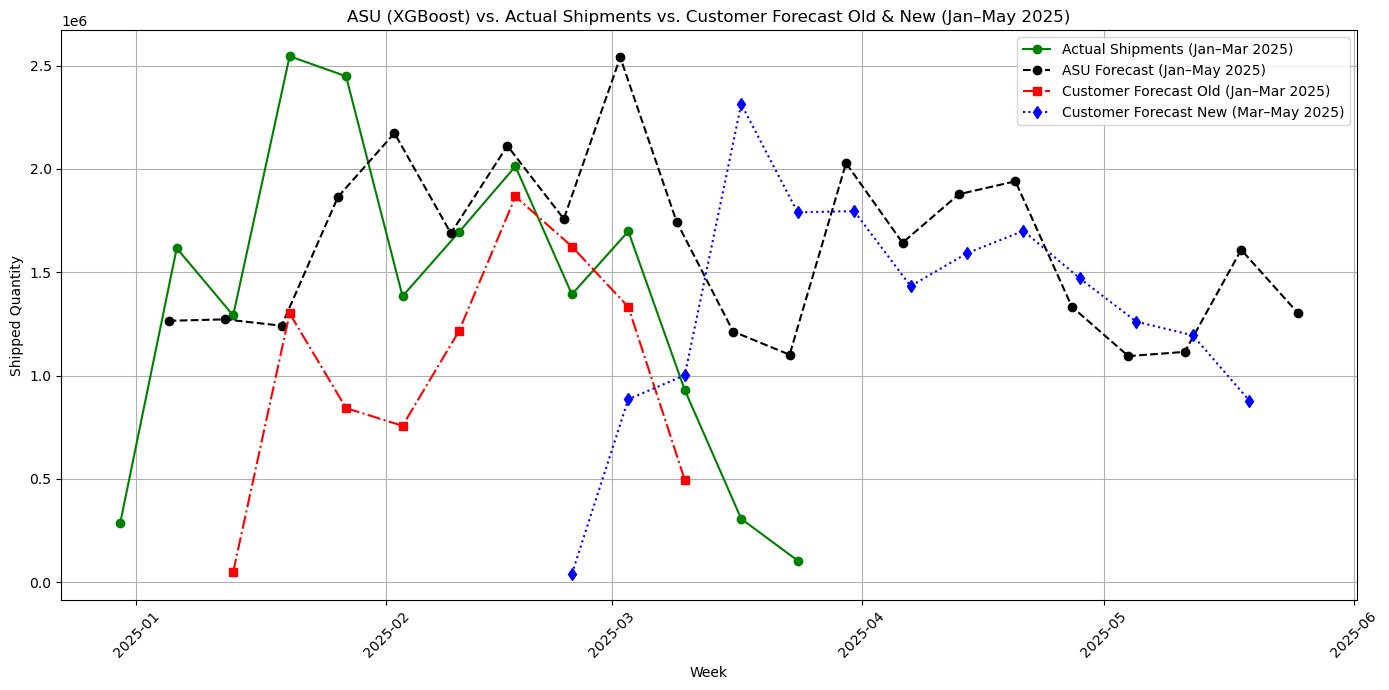

In [4]:
# Loading the customer forecast datasets (old and new)
forecast_1 = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Forecast Demand Capstone Data(Forecast Demand) (1).csv")
forecast_2 = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Forecast Demand Capstone Data(result).csv")

# Parse date columns to date-time format with flexible parsing
forecast_1['Required_Date'] = pd.to_datetime(forecast_1['Required_Date'], format='mixed')
forecast_2['Required_Date'] = pd.to_datetime(forecast_2['Required_Date'], format='mixed')

# Filtered and aggregated old customer forecast from Jan–Mar 2025
f1_weekly = forecast_1[
    (forecast_1['Required_Date'] >= '2025-01-01') &
    (forecast_1['Required_Date'] <= '2025-03-15')
].groupby(forecast_1['Required_Date'].dt.to_period('W'))['Forecast_Qty'].sum().to_timestamp()

#Filtered and aggregated new customer forecast from Mar–May 2025
f2_weekly = forecast_2[
    (forecast_2['Required_Date'] >= '2025-03-01') &
    (forecast_2['Required_Date'] <= '2025-05-31')
].groupby(forecast_2['Required_Date'].dt.to_period('W'))['Forecast_Qty'].sum().to_timestamp()

# === Plotting all 4 lines together actuals, ASU forecast, and customer forecasts===
plt.figure(figsize=(14, 7))

# Plot actual shipment data (Jan–Mar 2025)
plt.plot(actual_weekly, label='Actual Shipments (Jan–Mar 2025)', linestyle='-', marker='o', color='green')

# Plot ASU (XGBoost) forecast (Jan–May 2025)
plt.plot(forecast_series, label='ASU Forecast (Jan–May 2025)', linestyle='--', marker='o', color='black')

# Plot customer forecast from Jan–Mar 2025 (old)
plt.plot(f1_weekly, label='Customer Forecast Old (Jan–Mar 2025)', linestyle='-.', marker='s', color='red')

# Plot customer forecast from Mar–May 2025 (new)
plt.plot(f2_weekly, label='Customer Forecast New (Mar–May 2025)', linestyle=':', marker='d', color='blue')

# Chart formatting
plt.title("ASU (XGBoost) vs. Actual Shipments vs. Customer Forecast Old & New (Jan–May 2025)")
plt.xlabel("Week")
plt.ylabel("Shipped Quantity")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Customer-Wise XGBoost Forecasting**

In [5]:
print("\nStarting customer-wise XGBoost forecasting...\n")

# Step 1: Tag each row with a customer ID (using Site_Name here)
df['Customer_ID'] = df['Site_Name'].astype(str)
unique_customers = df['Customer_ID'].unique()

# This will hold forecast results for each customer
customer_forecasts = {}

# Step 2: Loop through each customer and build a separate forecast model
for customer in unique_customers:
    # Filter historical shipment data only for this customer and date range before 2025
    df_cust = df[df['Customer_ID'] == customer].copy()
    df_cust = df_cust[df_cust['Customer_Required_Date_CRD'] < '2025-01-01']

    # Aggregate weekly shipment quantities
    weekly = df_cust.groupby(df_cust['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum()
    weekly = weekly.to_timestamp().reset_index()
    weekly.rename(columns={'Customer_Required_Date_CRD': 'Week_Start'}, inplace=True)

    # Add calendar-based features
    weekly['Week'] = weekly['Week_Start'].dt.isocalendar().week
    weekly['Month'] = weekly['Week_Start'].dt.month
    weekly['Quarter'] = weekly['Week_Start'].dt.quarter

    # Add lag features and a 3-week rolling mean to help model patterns
    for lag in range(1, 6):
        weekly[f'Lag{lag}'] = weekly['Shipped_Qty'].shift(lag)
    weekly['RollingMean3'] = weekly['Shipped_Qty'].rolling(3).mean().shift(1)

    # Drop rows that now have NaNs due to lag/rolling ops
    weekly.dropna(inplace=True)
    weekly.reset_index(drop=True, inplace=True)

    # Add multi-step forecasting targets (t+1 to t+21)
    for step in range(1, horizon + 1):
        weekly[f'target_t+{step}'] = weekly['Shipped_Qty'].shift(-step)
    weekly.dropna(inplace=True)
    weekly.reset_index(drop=True, inplace=True)

    # Skip if not enough data to build a model
    if len(weekly) < 10:
        continue

    # Prepare features and targets
    features = ['Week', 'Month', 'Quarter', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RollingMean3']
    X = weekly[features]
    y_multi = weekly[[f'target_t+{i}' for i in range(1, horizon + 1)]]
    X_train, X_test = X.iloc[:-1], X.iloc[[-1]]
    y_train = y_multi.iloc[:-1]

    # Train 21 separate models, one for each future step (multi-output strategy)
    forecasts = []
    for i in range(horizon):
        model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
        model.fit(X_train, y_train[f'target_t+{i+1}'])
        pred = model.predict(X_test)[0]
        forecasts.append(pred)

    # Save forecasts in a pandas Series with proper weekly index
    forecast_dates = pd.date_range(start='2025-01-01', periods=horizon, freq='W')
    forecast_series = pd.Series(forecasts, index=forecast_dates)
    customer_forecasts[customer] = forecast_series

    print(f"Forecast complete for: {customer}")

print("\nAll customer-wise forecasts completed.\n")



Starting customer-wise XGBoost forecasting...

Forecast complete for: Factory Name 5
Forecast complete for: Factory Name 6
Forecast complete for: Factory Name 4
Forecast complete for: Factory Name 2
Forecast complete for: Factory Name 3
Forecast complete for: Factory Name 1
Forecast complete for: Factory Name 9
Forecast complete for: Factory Name 10
Forecast complete for: Factory Name 11
Forecast complete for: Factory Name 12
Forecast complete for: Factory Name 8
Forecast complete for: Factory Name 14

All customer-wise forecasts completed.



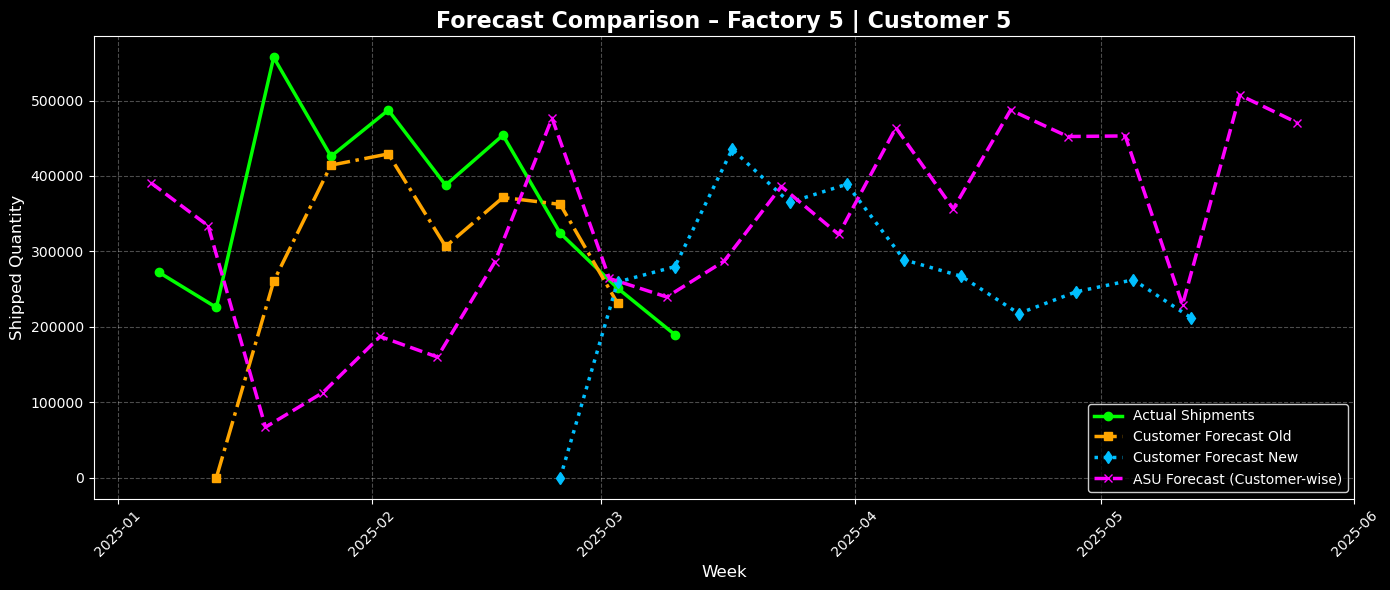

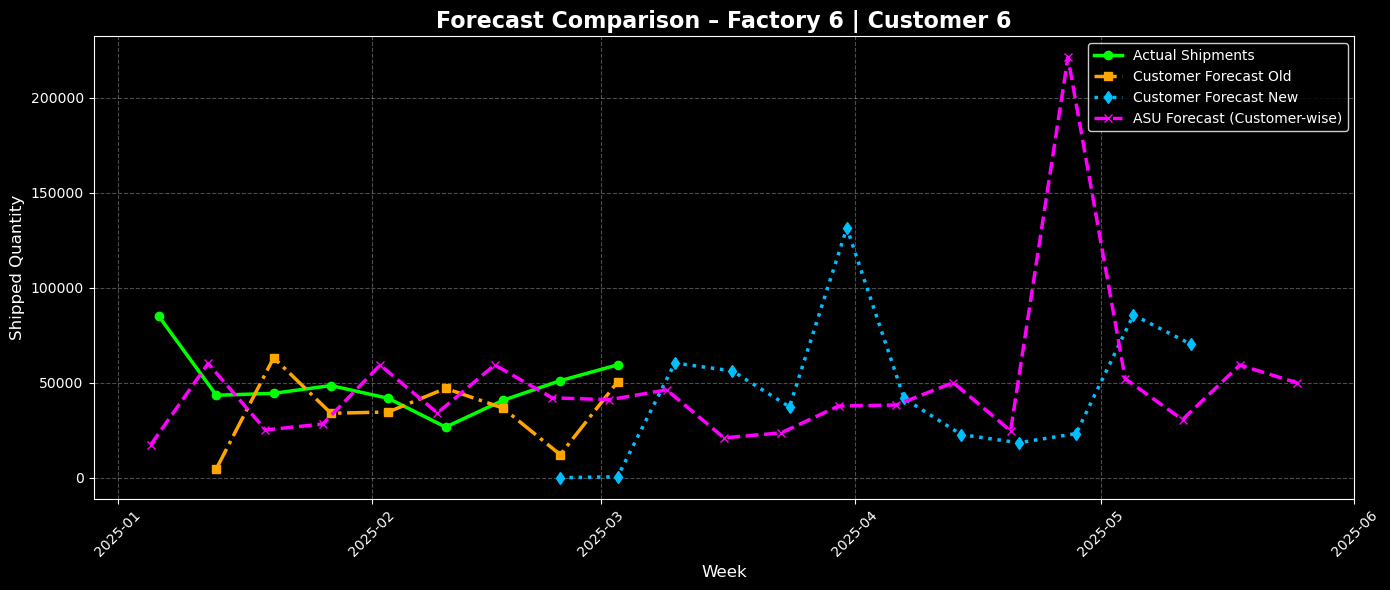

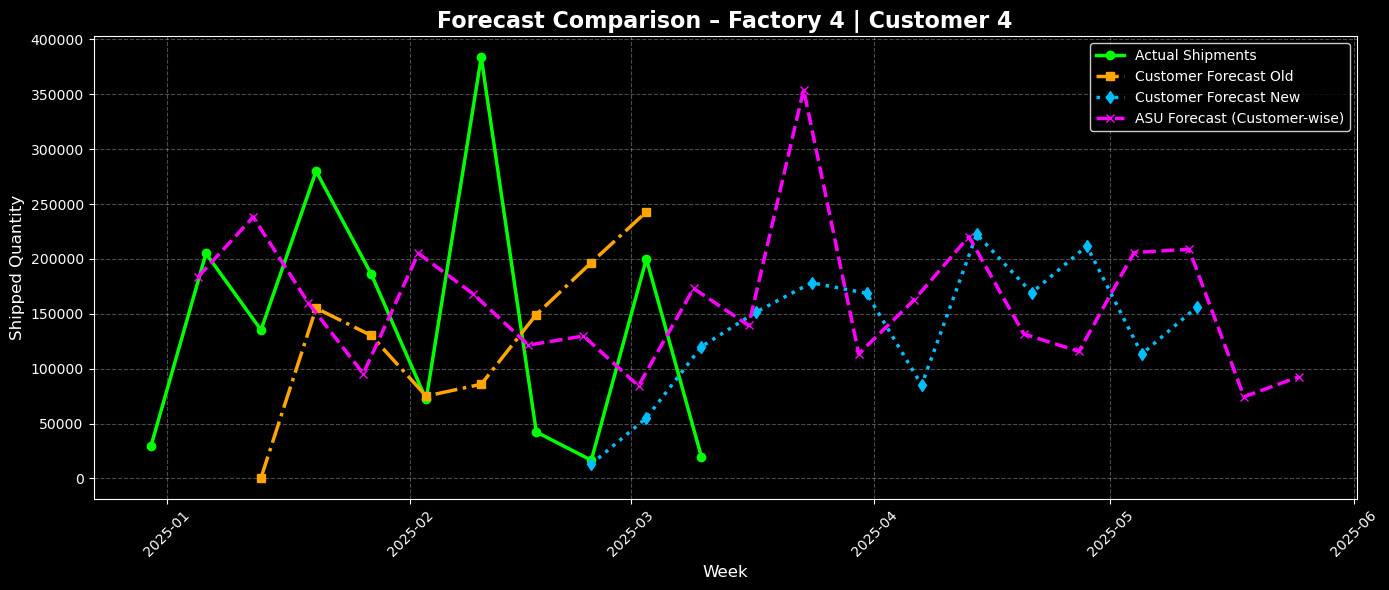

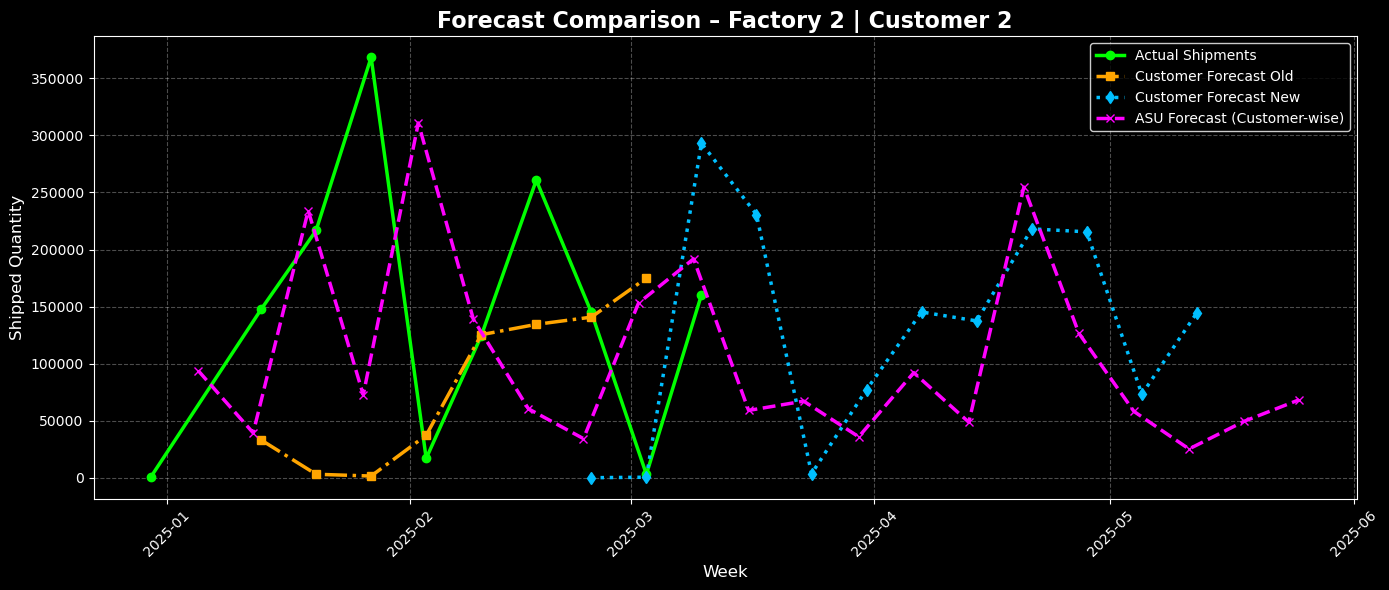

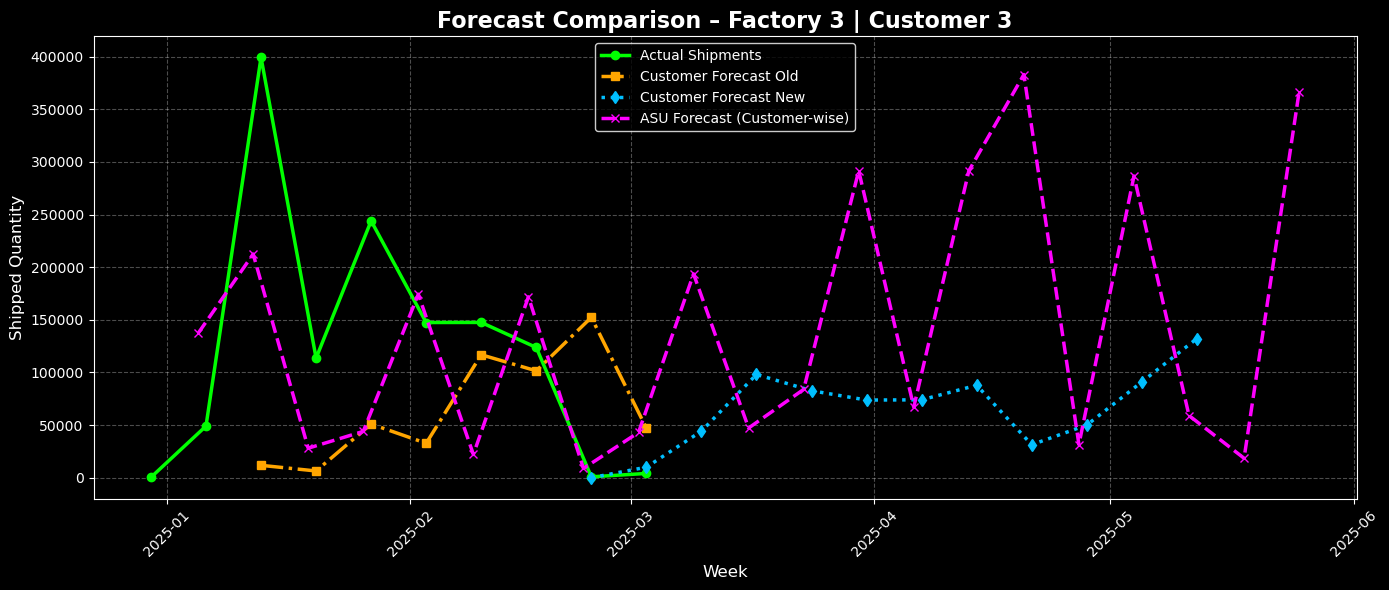

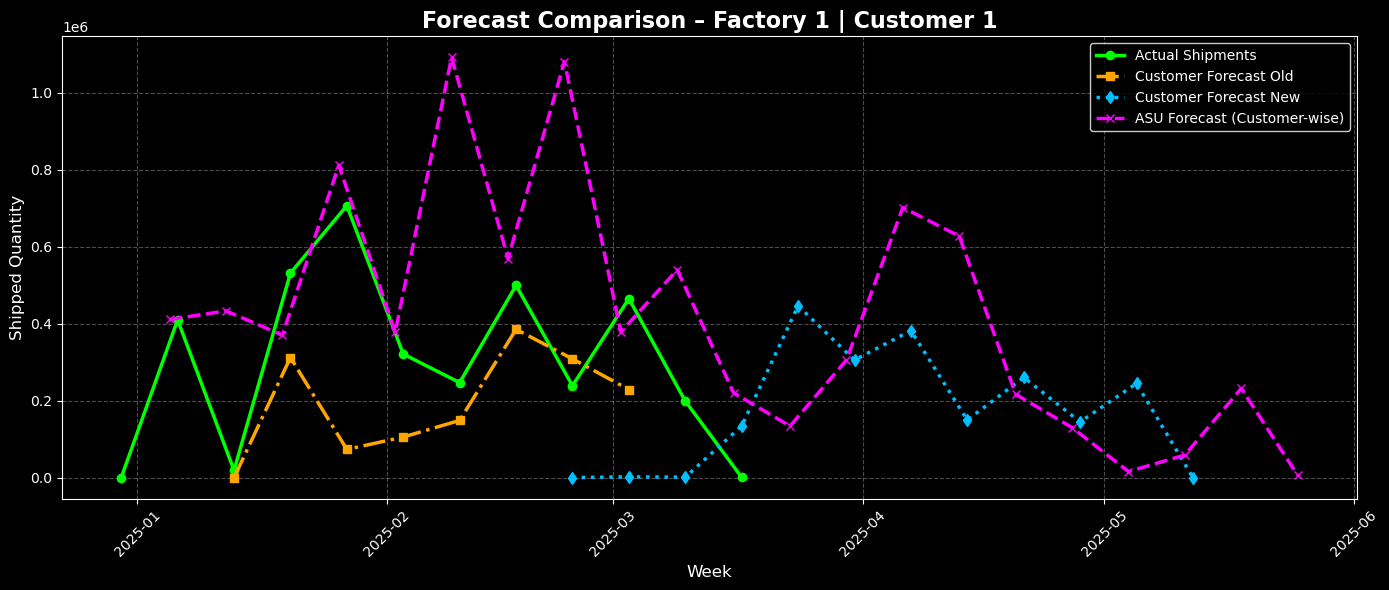

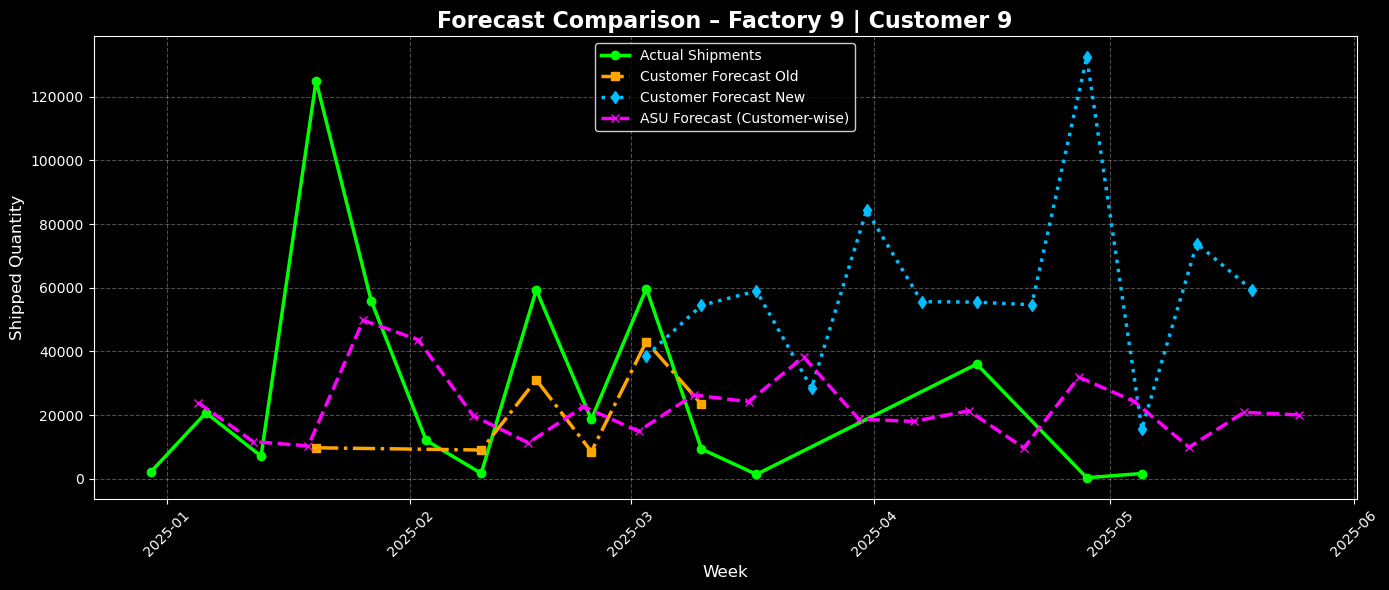

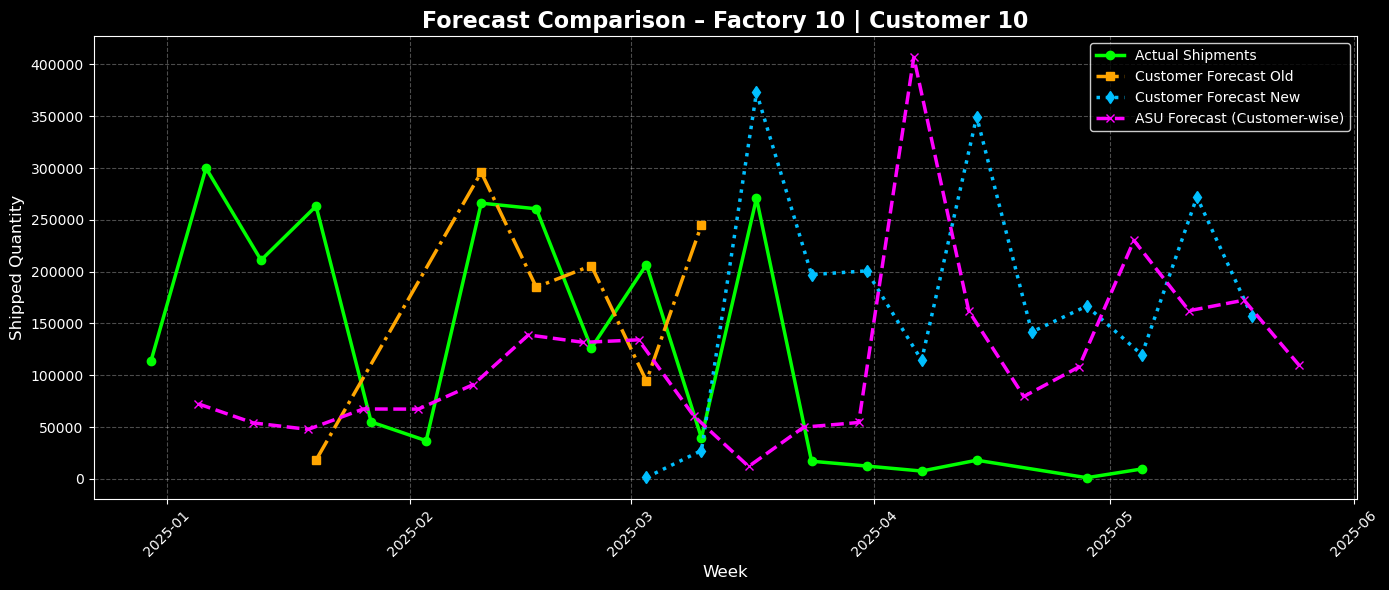

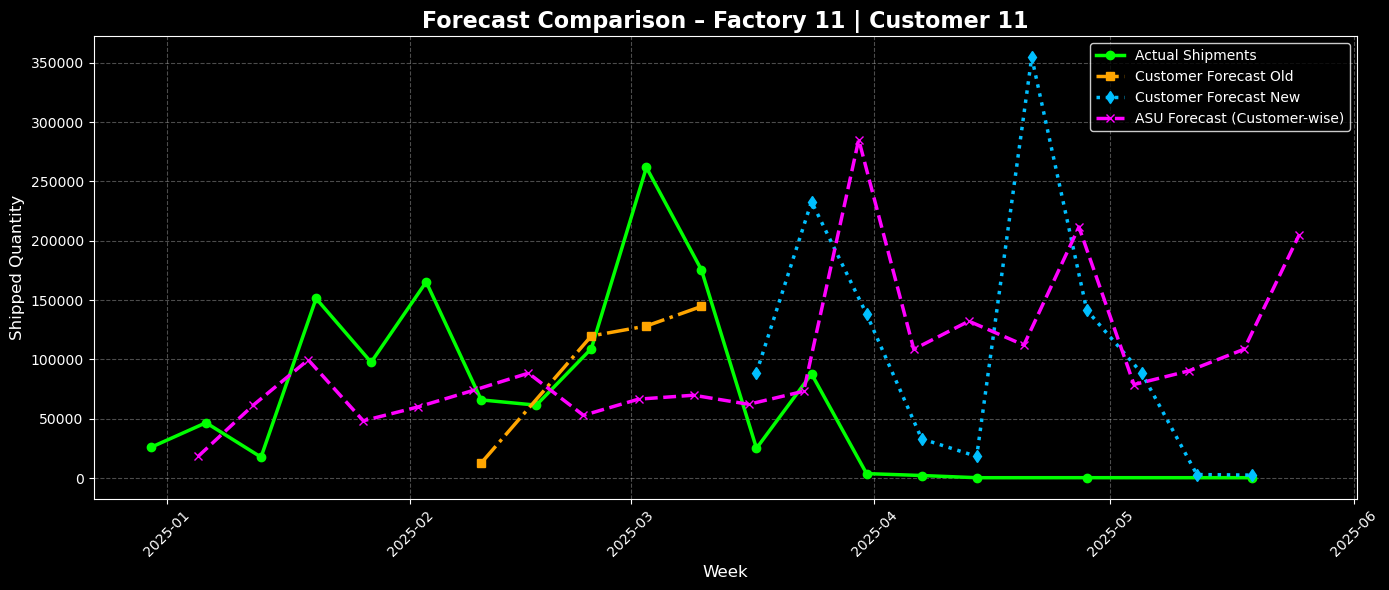

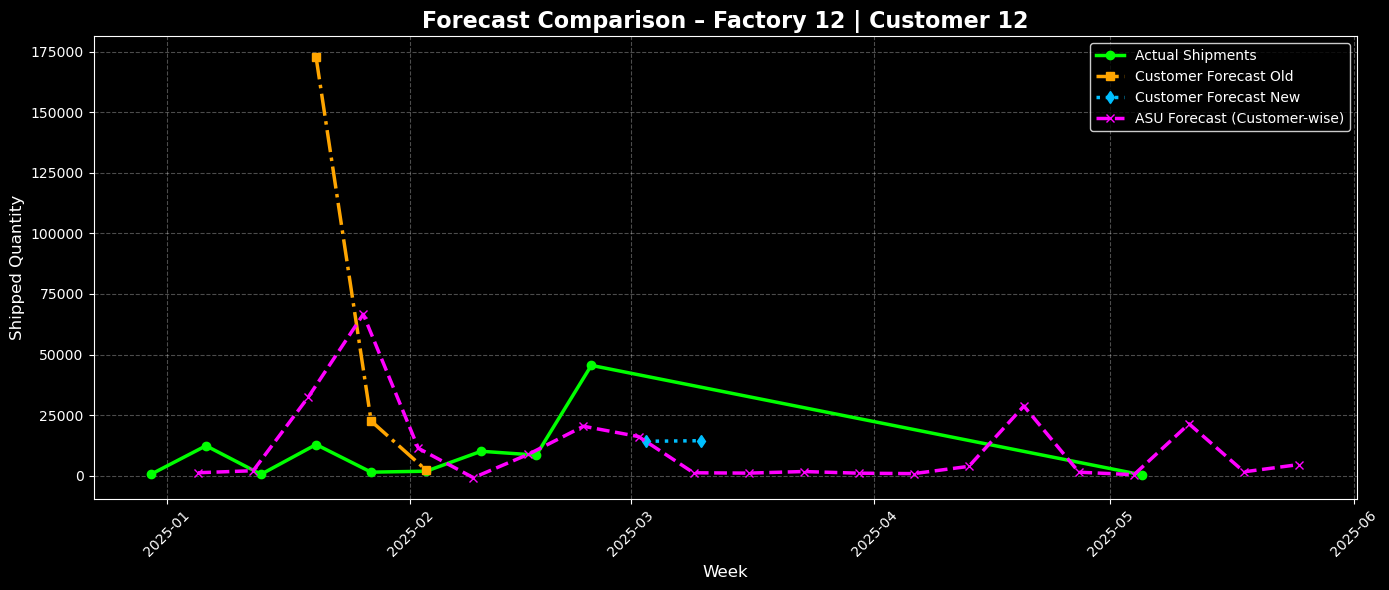

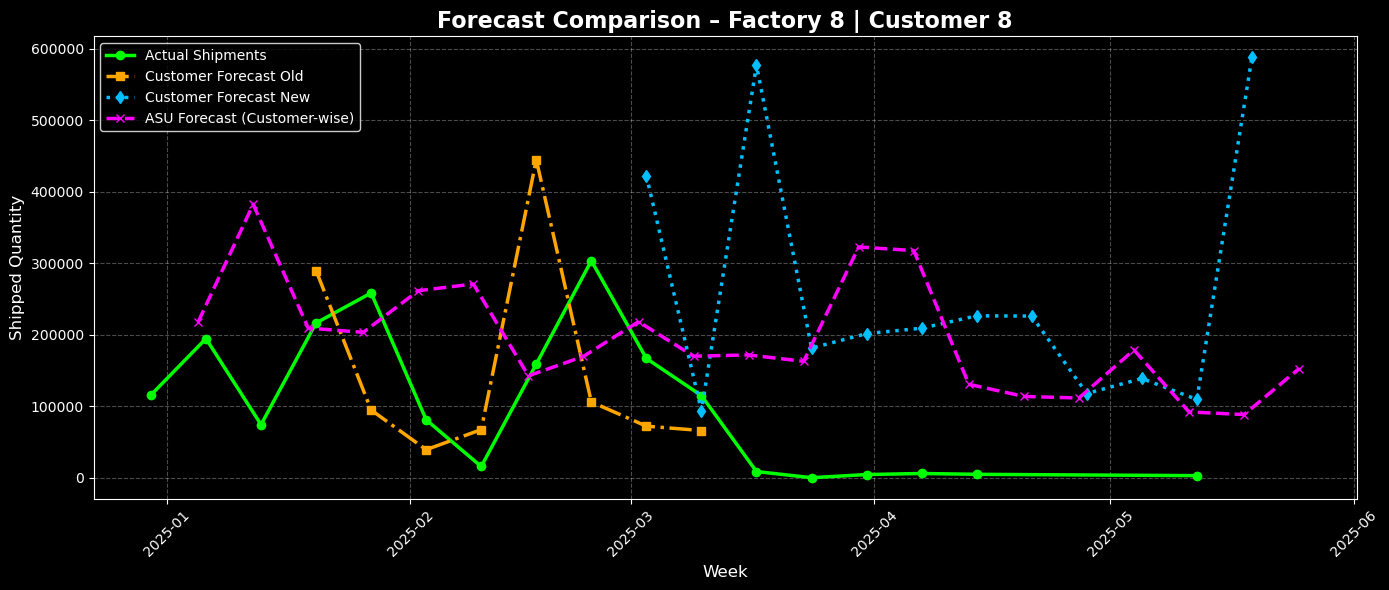

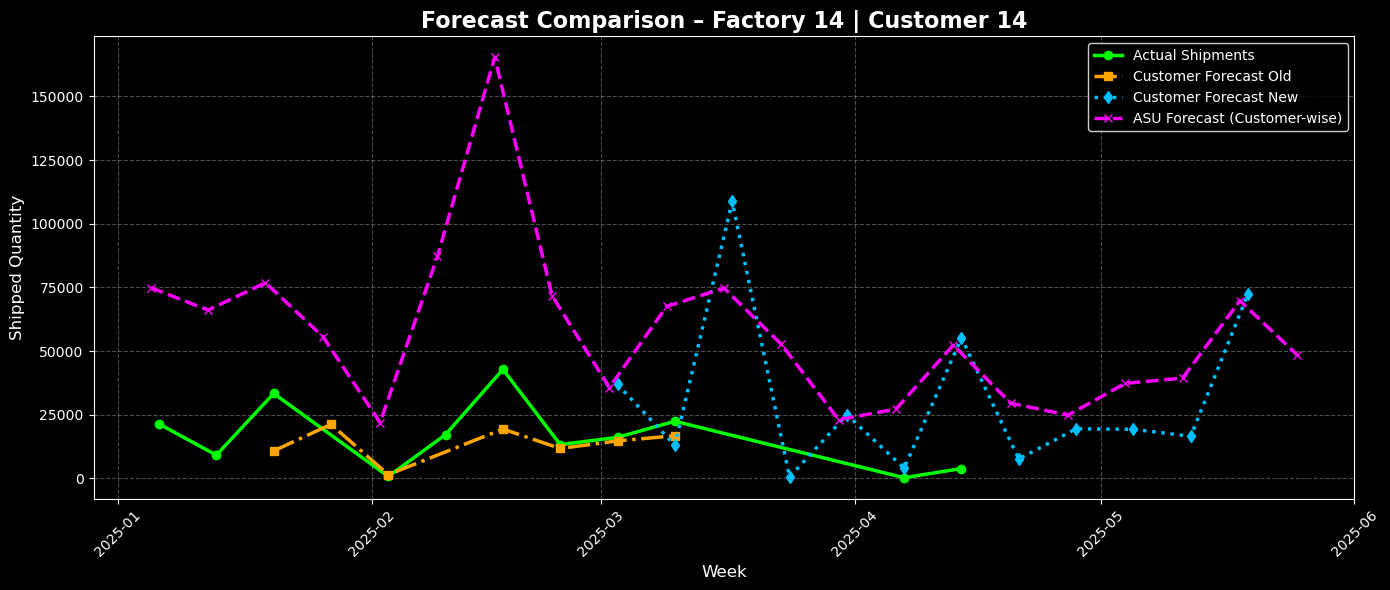

In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')  # Set dark theme for all plots (better contrast for dashboards)

# Assign customer IDs to both old and new forecast datasets for consistency
forecast_1['Customer_ID'] = forecast_1['Factory_Name'].astype(str)
forecast_2['Customer_ID'] = forecast_2['Factory_Name'].astype(str)

# Loop through each customer and generate a forecast comparison chart
for customer in customer_forecasts.keys():
    # Get actual shipment data for Jan–May 2025 for this customer
    actual_cust = df[(df['Customer_ID'] == customer) &
                     (df['Customer_Required_Date_CRD'] >= '2025-01-01') &
                     (df['Customer_Required_Date_CRD'] <= '2025-05-31')]
    actual_weekly = actual_cust.groupby(actual_cust['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum().to_timestamp()

    # Slice customer forecast from version 1 (older forecast) – Jan to mid-March
    f1_cust = forecast_1[(forecast_1['Customer_ID'] == customer) &
                         (forecast_1['Required_Date'] >= '2025-01-01') &
                         (forecast_1['Required_Date'] <= '2025-03-15')]

    # Slice customer forecast from version 2 (revised forecast) – March to May
    f2_cust = forecast_2[(forecast_2['Customer_ID'] == customer) &
                         (forecast_2['Required_Date'] >= '2025-03-01') &
                         (forecast_2['Required_Date'] <= '2025-05-31')]

    # Weekly aggregation of both forecasts
    f1_weekly = f1_cust.groupby(f1_cust['Required_Date'].dt.to_period('W'))['Forecast_Qty'].sum().to_timestamp()
    f2_weekly = f2_cust.groupby(f2_cust['Required_Date'].dt.to_period('W'))['Forecast_Qty'].sum().to_timestamp()

    # Start the chart
    plt.figure(figsize=(14, 6))

    # Plot actual shipment line
    if not actual_weekly.empty:
        plt.plot(actual_weekly.index, actual_weekly.values, label='Actual Shipments',
                 marker='o', color='lime', linewidth=2.5)

    # Plot customer old forecast
    if not f1_weekly.empty:
        plt.plot(f1_weekly.index, f1_weekly.values, label='Customer Forecast Old',
                 linestyle='-.', marker='s', color='orange', linewidth=2.5)

    # Plot customer new forecast
    if not f2_weekly.empty:
        plt.plot(f2_weekly.index, f2_weekly.values, label='Customer Forecast New',
                 linestyle=':', marker='d', color='deepskyblue', linewidth=2.5)

    # Plot ASU-generated forecast (from XGBoost model)
    plt.plot(customer_forecasts[customer].index, customer_forecasts[customer].values,
             label='ASU Forecast (Customer-wise)', linestyle='--', marker='x',
             color='magenta', linewidth=2.5)

    # Generate a clean title from numeric part of customer ID
    import re
    match = re.search(r'\d+', customer)
    cust_num = match.group() if match else "Unknown"
    plt.title(f"Forecast Comparison – Factory {cust_num} | Customer {cust_num}",
              fontsize=16, fontweight='bold', color='white')

    # Styling the axes
    plt.xlabel("Week", fontsize=12, color='white')
    plt.ylabel("Shipped Quantity", fontsize=12, color='white')
    plt.xticks(rotation=45, color='white')
    plt.yticks(color='white')
    plt.grid(True, linestyle='--', alpha=0.3)

    # Legend styling
    plt.legend(facecolor='black', edgecolor='white', fontsize=10)
    plt.tight_layout()
    plt.show()